<h1 align = 'center'>Case Técnico - Cientista de Dados Júnior - Datarisk</h1>

## 1. Introdução

O objetivo deste projeto é desenvolver um modelo preditivo capaz de estimar a probabilidade de inadimplência, utilizando as bases de dados disponibilizadas pela empresa. A tarefa envolve desde a compreensão das estruturas e relações entre as tabelas até a construção de um pipeline completo de preparação dos dados, exploração, feature engineering, modelagem e avaliação.

Para isso, conduzimos um processo estruturado composto pelas seguintes etapas:

- Análise e consolidação das bases fornecidas, respeitando os relacionamentos entre clientes, informações mensais e registros de cobrança;

- Exploração estatística e visual dos dados, com foco em entender padrões relevantes para inadimplência;

- Tratamento de valores ausentes, transformação de variáveis e criação de novas features, garantindo que o dataset final esteja adequado à modelagem;

- Construção e avaliação de modelos supervisionados, incluindo Regressão Logística, Random Forest e XGBoost, comparados por métricas adequadas para dados desbalanceados (AUC-ROC e Log Loss);

- Validação cruzada e ajuste de hiperparâmetros do modelo final selecionado, reforçando estabilidade e capacidade de generalização;

- Geração das probabilidades de inadimplência para o conjunto de teste, conforme solicitado no case.

O trabalho foi conduzido com foco em clareza metodológica, reprodutibilidade e rigor analítico, estruturando todas as etapas de forma transparente e baseada em boas práticas de ciência de dados para problemas de risco de crédito.

## 2. Importação das Bibliotecas 

Nesta seção, importamos todas as bibliotecas necessárias para o projeto, organizadamente por categoria (manipulação, visualização, modelagem e utilidades).  
Também padronizamos configurações globais para garantir reprodutibilidade.

In [ ]:
# Manipulação e análise de dados
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações gerais
RANDOM_STATE = 0
sns.set_theme(style = 'whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

## 3. Leitura das Bases 

Nesta seção, faremos a leitura inicial dos dados fornecidos para análise. 

In [37]:
# Define o caminho dos dados
path = './data/'

base_cadastral = pd.read_csv(path + 'base_cadastral.csv', sep = ';')
base_info = pd.read_csv(path + 'base_info.csv', sep = ';')
base_dev = pd.read_csv(path + 'base_pagamentos_desenvolvimento.csv', sep = ';')
base_test = pd.read_csv(path + 'base_pagamentos_teste.csv', sep = ';')

In [ ]:
# Exibe os shapes das bases de dados
print('\nShapes:')
print('base_cadastral:', base_cadastral.shape)
print('base_info:', base_info.shape)
print('base_dev:', base_dev.shape)
print('base_test:', base_test.shape)


Shapes:
base_cadastral: (1315, 8)
base_info: (24401, 4)
base_dev: (77414, 7)
base_test: (12275, 6)


A seguir, exibimos as primeiras linhas das quatro bases fornecidas, com o objetivo de inspecionar sua estrutura e compreender o papel de cada uma no processo de modelagem.

In [39]:
# Exibe o head da base cadastral
base_cadastral.head()

,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230676,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65
1,8274986328479596038,2017-01-25,31,NaN,Comércio,YAHOO,MEDIO,77
2,345447888460137901,2000-08-15,75,NaN,Serviços,HOTMAIL,PEQUENO,48
3,1003144834589372198,2017-08-06,49,NaN,Serviços,OUTLOOK,PEQUENO,89
4,324916756972236008,2011-02-14,88,NaN,Serviços,GMAIL,GRANDE,62


In [40]:
# Exibe o head da base de informações
base_info.head()

,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-09,16913.0,NaN
1,8274986328479596038,2018-09,106430.0,141.0
2,345447888460137901,2018-09,707439.0,99.0
3,1003144834589372198,2018-09,239659.0,96.0
4,324916756972236008,2018-09,203123.0,103.0


In [41]:
# Exibe o head da base de desenvolvimento
base_dev.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99


In [42]:
# Exibe o head da base de teste
base_test.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99


A tabela a abaixo resume os tipos de dados de cada base, permitindo identificar colunas que exigem padronização, especialmente datas e 
variáveis temporais importadas como tipos genéricos (`object` ou `int`). 

In [43]:
# Cria um DataFrame com os tipos de dados de cada base
tipos = {
    "base_cadastral": base_cadastral.dtypes,
    "base_info": base_info.dtypes,
    "base_dev": base_dev.dtypes,
    "base_test": base_test.dtypes,
}

pd.DataFrame(tipos)

,base_cadastral,base_info,base_dev,base_test
CEP_2_DIG,object,NaN,NaN,NaN
DATA_CADASTRO,object,NaN,NaN,NaN
DATA_EMISSAO_DOCUMENTO,NaN,NaN,object,object
DATA_PAGAMENTO,NaN,NaN,object,NaN
DATA_VENCIMENTO,NaN,NaN,object,object
DDD,object,NaN,NaN,NaN
DOMINIO_EMAIL,object,NaN,NaN,NaN
FLAG_PF,object,NaN,NaN,NaN
ID_CLIENTE,int64,int64,int64,int64
NO_FUNCIONARIOS,NaN,float64,NaN,NaN


A análise dos tipos mostra que as bases apresentam estruturas distintas, com datas importadas como `object`, variáveis numéricas distribuídas entre diferentes tabelas e colunas presentes apenas em algumas bases. Essa revisão é importante para orientar a padronização que será realizada na próxima etapa, garantindo que todas as variáveis estejam no formato adequado antes dos merges e da construção da variável-alvo.

A tabela abaixo apresenta um resumo consolidado das quatro bases de dados utilizadas no projeto. 
Para cada base, avaliamos:

- número total de linhas e colunas;
- quantidade absoluta de valores faltantes;
- percentual máximo de missing observado em alguma coluna;
- coluna mais crítica em termos de ausência de dados.

Essa visão permite identificar rapidamente problemas estruturais nas bases antes de proceder com as etapas subsequentes, como a limpeza, padronização de datas, merges e construção da variável alvo.

In [ ]:
# Cria um DataFrame resumido com informações sobre missings em cada base
bases = {
    'base_cadastral': base_cadastral,
    'base_info': base_info,
    'base_dev': base_dev,
    'base_test': base_test,
}

resumo = []

for nome, df in bases.items():
    missing_abs = df.isnull().sum()
    missing_pct = df.isnull().mean() * 100
    
    resumo.append({
        'base': nome,
        'linhas': df.shape[0],
        'colunas': df.shape[1],
        'missings_totais': int(missing_abs.sum()),
        'missings_máx_%': round(missing_pct.max(), 2),
        'coluna_mais_nula': missing_pct.idxmax()
    })

resumo_df = pd.DataFrame(resumo)
resumo_df

,base,linhas,colunas,missings_totais,missings_máx_%,coluna_mais_nula
0,base_cadastral,1315,8,1640,94.98,FLAG_PF
1,base_info,24401,4,1969,5.13,NO_FUNCIONARIOS
2,base_dev,77414,7,1170,1.51,VALOR_A_PAGAR
3,base_test,12275,6,131,1.07,VALOR_A_PAGAR


Com base nesses indicadores, observamos:

- a base **cadastral** possui uma coluna (`FLAG_PF`) com nível elevado de valores ausentes, o que merece atenção em etapas posteriores;
- nas demais bases, os níveis de dados ausentes são baixos e não sugerem problemas relevantes de qualidade; 
- no conjunto geral, as bases apresentam boa consistência e estão adequadas para avançar para as próximas etapas da análise.

Dessa forma, seguimos para a padronização das variáveis de data e, posteriormente, para a construção da variável-alvo.

## 4. Conversão de Datas e Padronização 

Antes de avançar para os merges e para a construção da variável-alvo, é importante garantir que as variáveis de data estejam no formato adequado (`datetime`) e que o identificador temporal `SAFRA_REF` esteja padronizado.

Embora `SAFRA_REF` já apareça como `object` nas bases, essa coluna representa o mês de referência da amostra e deve ser tratada explicitamente como identificador textual, para evitarmos inconsistências e possíveis divergências nos merges.

As colunas de data, por sua vez, foram importadas como `object` e precisam ser convertidas para `datetime` para permitir operações temporais corretas.

In [ ]:
# Conversão de datas na base cadastral
base_cadastral['DATA_CADASTRO'] = pd.to_datetime(
    base_cadastral['DATA_CADASTRO'], errors = "coerce"
)

# Conversão de datas na base de desenvolvimento
for col in ['DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO', 'DATA_PAGAMENTO']:
    base_dev[col] = pd.to_datetime(base_dev[col], errors = "coerce")

# Conversão de datas na base de teste (não possui DATA_PAGAMENTO)
for col in ['DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO']:
    base_test[col] = pd.to_datetime(base_test[col], errors = "coerce")

# Padronização da SAFRA_REF como string (identificador temporal)
for df in [base_info, base_dev, base_test]:
    df['SAFRA_REF'] = df['SAFRA_REF'].astype(str).str.strip()

A célula abaixo confirma a conversão correta das colunas de data.

In [ ]:
# Verifica que as datas foram convertidas corretamente
base_dev[['DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO', 'DATA_PAGAMENTO']].dtypes

DATA_EMISSAO_DOCUMENTO    datetime64[ns]
DATA_VENCIMENTO           datetime64[ns]
DATA_PAGAMENTO            datetime64[ns]
dtype: object

Concluída a etapa de padronização, as bases estão prontas para a definição da variável-alvo.

## 5. Construção da Variável Alvo

O objetivo do case é estimar a probabilidade de inadimplência para cada cobrança. O enunciado define explicitamente que um pagamento é considerado inadimplente se for realizado com **5 dias ou mais de atraso** em relação à data de vencimento.

A base de desenvolvimento contém tanto `DATA_VENCIMENTO` quanto `DATA_PAGAMENTO`, permitindo calcular o atraso em dias. A partir dessa informação, construímos a variável-alvo (`TARGET`) da seguinte forma:

- `TARGET = 1` ⟶ inadimplente (atraso ≥ 5 dias);
- `TARGET = 0` ⟶ adimplente (atraso < 5 dias).

In [47]:
# Cálculo do atraso em dias
base_dev['DIAS_ATRASO'] = (base_dev['DATA_PAGAMENTO'] - base_dev['DATA_VENCIMENTO']).dt.days

# Construção da variável alvo: 1 se houve atraso, 0 caso contrário
base_dev['TARGET'] = (base_dev['DIAS_ATRASO'] >= 5).astype(int)

# Visualização
base_dev[['DIAS_ATRASO', 'DATA_PAGAMENTO', 'DATA_VENCIMENTO', 'TARGET']].head(30)

,DIAS_ATRASO,DATA_PAGAMENTO,DATA_VENCIMENTO,TARGET
0,0,2018-09-06,2018-09-06,0
1,1,2018-09-11,2018-09-10,0
2,1,2018-09-18,2018-09-17,0
3,6,2018-10-11,2018-10-05,1
4,0,2018-09-20,2018-09-20,0
5,0,2018-09-25,2018-09-25,0
6,0,2018-09-05,2018-09-05,0
7,0,2018-09-03,2018-09-03,0
8,0,2018-09-03,2018-09-03,0
9,0,2018-09-05,2018-09-05,0


In [48]:
base_dev['TARGET'].value_counts(normalize = True).rename("proporção")

TARGET
0    0.92978
1    0.07022
Name: proporção, dtype: float64

A distribuição da variável-alvo indica que cerca de 7% das cobranças foram classificadas como inadimplentes (atraso ≥ 5 dias). Esse desbalanceamento é esperado e será um ponto importante nas etapas de análise exploratória e na definição da estratégia de modelagem.

## 6. Consolidação das Bases

A consolidação das bases segue a estrutura de relacionamento descrita no case. De acordo com o diagrama fornecido:

- A base **cadastral** se relaciona com a base de pagamentos via `ID_CLIENTE` (1:N);
- A base **info** se relaciona com a base de pagamentos via `ID_CLIENTE` e `SAFRA_REF` (1:N).

A relação **1:N** entre a base cadastral e a base de pagamentos significa que cada cliente aparece apenas uma vez na base cadastral, mas pode ter várias cobranças registradas ao longo do tempo, resultando em múltiplas linhas na base de pagamentos.

A relação **1:N** entre a base info e a base de pagamentos (via `ID_CLIENTE` e `SAFRA_REF`) indica que, para cada cliente em um determinado mês de referência, existe no máximo um registro de informações mensais em `base_info`, que pode estar associado a várias cobranças desse mesmo período na base de pagamentos.

A consolidação é feita separadamente para:
- a base de **desenvolvimento**, que contém a variável-alvo `TARGET`;
- a base de **teste**, que precisa das mesmas features para predição.  

Após os merges, cada linha representará uma cobrança individual, munida com os atributos cadastrais e informações mensais do cliente.   
Utilizamos `how = "left"` (left join) nos merges porque a base de pagamentos é a tabela fato do problema. Assim, preservamos todas as cobranças mesmo quando um cliente não possui informações cadastrais ou mensais completas. Essa abordagem evita perda de observações e garante consistência nas etapas de modelagem.

In [49]:
# Merge entre base_dev e base_cadastral (left join)
dev_full = base_dev.merge(
    base_cadastral,
    on = 'ID_CLIENTE',
    how = 'left',
)

# Merge entre dev_full e base_info (mensal)
dev_full = dev_full.merge(
    base_info,
    on = ['ID_CLIENTE', 'SAFRA_REF'],
    how = 'left'
)

print(dev_full.shape)
dev_full.head()

(77414, 18)


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIAS_ATRASO,TARGET,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,0,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65,NaN,NaN
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,1,0,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65,NaN,NaN
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,1,0,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65,NaN,NaN
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,6,1,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65,NaN,NaN
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0,0,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65,NaN,NaN


In [50]:
# Merge entre base_test e base_cadastral (left join)
test_full = base_test.merge(
    base_cadastral,
    on = 'ID_CLIENTE',
    how = 'left',
)

# Merge entre test_full e base_info (mensal)
test_full = test_full.merge(
    base_info,
    on = ['ID_CLIENTE', 'SAFRA_REF'],
    how = 'left'
)

print(test_full.shape)
test_full.head()

(12275, 15)


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,5058298901476893676,2021-07,2021-07-14,2021-08-04,11204.75,4.99,2014-03-30,54,NaN,Serviços,GMAIL,MEDIO,99,467430.0,NaN
1,274692171162531764,2021-07,2021-07-08,2021-08-23,60718.50,5.99,2005-08-03,19,NaN,Serviços,GMAIL,PEQUENO,13,417192.0,104.0
2,274692171162531764,2021-07,2021-07-11,2021-08-25,60718.50,5.99,2005-08-03,19,NaN,Serviços,GMAIL,PEQUENO,13,417192.0,104.0
3,274692171162531764,2021-07,2021-07-16,2021-08-30,62250.00,5.99,2005-08-03,19,NaN,Serviços,GMAIL,PEQUENO,13,417192.0,104.0
4,465309249432033993,2021-07,2021-07-05,2021-07-30,26593.95,6.99,2014-07-23,69,NaN,Comércio,GMAIL,GRANDE,76,873938.0,119.0


In [51]:
# Verifica se o merge gerou duplicações indesejadas
dev_full.duplicated(subset = ['ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO']).sum()

np.int64(8402)

Esse número é esperado, pois um mesmo cliente pode ter várias cobranças emitidas na mesma data. Portanto, essa verificação não indica problema nos merges.

In [52]:
# Avalia os campos com maiores proporções de valores ausentes após a consolidação
dev_full.isnull().mean().sort_values(ascending = False).head(10)

FLAG_PF                0.997171
NO_FUNCIONARIOS        0.098006
DDD                    0.095771
RENDA_MES_ANTERIOR     0.079210
PORTE                  0.031984
SEGMENTO_INDUSTRIAL    0.018304
VALOR_A_PAGAR          0.015114
DOMINIO_EMAIL          0.011600
SAFRA_REF              0.000000
ID_CLIENTE             0.000000
dtype: float64

Os valores ausentes refletem clientes que não possuem informação cadastral ou mensal em determinados períodos, o que é natural dado o uso de left join.  
Não há indícios de inconsistências estruturais nos dados.

In [53]:
# Garante que o número de linhas foi preservado após o merge
len(base_dev), len(dev_full)

(77414, 77414)

In [54]:
# Verifica se a base_info possui no máximo um registro por (ID_CLIENTE, SAFRA_REF)
base_info.groupby(['ID_CLIENTE', 'SAFRA_REF']).size().max()

np.int64(1)

In [55]:
# Verifica se existe mais de um registro por ID_CLIENTE na base cadastral
base_cadastral['ID_CLIENTE'].duplicated().sum()

np.int64(0)

Essas verificações confirmam que a consolidação preservou a estrutura das bases: o número de linhas da base de pagamentos não foi alterado, a `base_info` possui no máximo um registro por (`ID_CLIENTE`, `SAFRA_REF`) e a `base_cadastral` não apresenta clientes duplicados. Assim, os merges não introduziram duplicações artificiais e a base consolidada está consistente.  

## 7. Análise Exploratória de Dados (EDA)

### 7.1. Introdução à EDA

Nesta seção realizamos uma análise exploratória voltada a entender o perfil das cobranças, dos clientes e da variável de interesse (`TARGET`). O objetivo não é explorar exaustivamente cada coluna, mas identificar padrões relevantes para a modelagem, potenciais outliers e relações iniciais entre variáveis que possam impactar a inadimplência.

### 7.2. Distribuição da Variável Alvo

In [56]:
# Distribuição da variável alvo
target_counts = dev_full['TARGET'].value_counts(normalize = True)
target_counts

TARGET
0    0.92978
1    0.07022
Name: proportion, dtype: float64

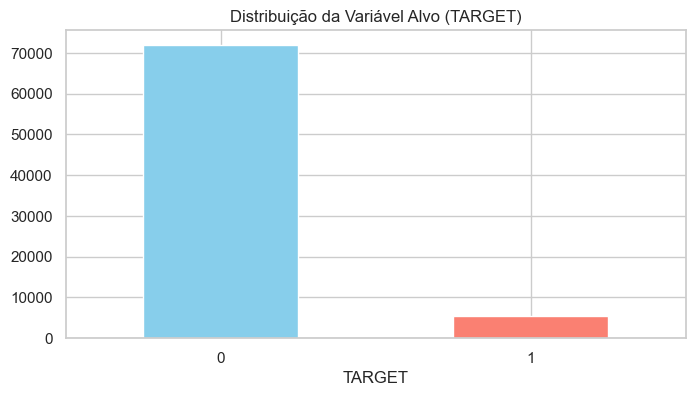

In [57]:
# Visualização da distribuição da variável alvo
dev_full['TARGET'].value_counts().plot(kind = 'bar', color = ['skyblue', 'salmon'])
plt.title('Distribuição da Variável Alvo (TARGET)')
plt.xticks(rotation = 0)
plt.show()

Observamos um desbalanceamento significativo na variável-alvo, com aproximadamente 7% das cobranças classificadas como inadimplentes (TARGET = 1) e 93% como adimplentes  
(TARGET = 0). Esse padrão é comum em problemas de crédito e deve ser considerado nas estratégias de modelagem, especialmente na escolha de métricas de avaliação e técnicas para lidar com o desbalanceamento.

### 7.3. Checagem dos Valores Ausentes

In [58]:
# Checagem dos valores ausentes nas 15 variáveis com maior proporção de dados faltantes
dev_full.isnull().mean().sort_values(ascending = False).head(15)

FLAG_PF                0.997171
NO_FUNCIONARIOS        0.098006
DDD                    0.095771
RENDA_MES_ANTERIOR     0.079210
PORTE                  0.031984
SEGMENTO_INDUSTRIAL    0.018304
VALOR_A_PAGAR          0.015114
DOMINIO_EMAIL          0.011600
SAFRA_REF              0.000000
ID_CLIENTE             0.000000
DATA_CADASTRO          0.000000
TARGET                 0.000000
DIAS_ATRASO            0.000000
TAXA                   0.000000
DATA_VENCIMENTO        0.000000
dtype: float64

A análise de valores ausentes indica que a maior parte dos missing está concentrada em variáveis cadastrais e informacionais (`FLAG_PF`, `NO_FUNCIONARIOS`, `DDD` `RENDA_MES_ANTERIOR`).  
Esses valores são esperados devido ao uso de left join e serão tratados na próxima seção de Feature Engineering. A variável `FLAG_PF` apresenta quase 100% de ausência, sugerindo que possivelmente deve ser descartada.


### 7.4. Estatísticas das Variáveis Numéricas

In [59]:
# Estatísticas descritivas das variáveis numéricas
dev_full[['VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']].describe()

,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
count,7.624400e+04,77414.000000,7.128200e+04,69827.000000
mean,4.659078e+04,6.789623,2.914381e+05,117.692812
std,4.643393e+04,1.798225,2.132932e+05,18.779624
min,1.000000e-01,4.990000,1.050000e+02,0.000000
25%,1.876536e+04,5.990000,1.340742e+05,105.000000
50%,3.475869e+04,5.990000,2.405020e+05,118.000000
75%,6.093384e+04,6.990000,3.962500e+05,130.000000
max,4.400000e+06,11.990000,1.682759e+06,198.000000


As variáveis numéricas têm distribuições bastante assimétricas e escalas diferentes entre si, especialmente `VALOR_A_PAGAR` e `RENDA_MES_ANTERIOR`, que apresentam valores muito altos e alguns outliers. Esse comportamento é comum em variáveis financeiras e indica que transformações como padronização ou escalonamento podem ser úteis na etapa de Feature
Engineering. A variável `TAXA` possui poucos valores possíveis, enquanto `NO_FUNCIONARIOS` é mais concentrada em torno da mediana.


### 7.5. Análise das Variáveis Categóricas

In [60]:
# Avaliação das distribuições das variáveis categóricas
cat_cols = ['SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG'] 
for col in cat_cols: 
    print('\n---', col, '---')
    print(dev_full[col].value_counts(normalize = True).head())


--- SEGMENTO_INDUSTRIAL ---
SEGMENTO_INDUSTRIAL
Serviços     0.416306
Comércio     0.356093
Indústria    0.227601
Name: proportion, dtype: float64

--- DOMINIO_EMAIL ---
DOMINIO_EMAIL
YAHOO      0.330937
GMAIL      0.279772
HOTMAIL    0.244145
OUTLOOK    0.062837
AOL        0.058236
Name: proportion, dtype: float64

--- PORTE ---
PORTE
MEDIO      0.399383
GRANDE     0.387414
PEQUENO    0.213203
Name: proportion, dtype: float64

--- CEP_2_DIG ---
CEP_2_DIG
13    0.050223
35    0.036750
68    0.033624
89    0.033431
86    0.027579
Name: proportion, dtype: float64


As variáveis categóricas apresentam distribuições concentradas e sem categorias excessivamente raras. `SEGMENTO_INDUSTRIAL`, `DOMINIO_EMAIL` e `PORTE` possuem poucas categorias dominantes, enquanto `CEP_2_DIG` é mais dispersa, mas ainda adequada para codificação simples. No geral, essas variáveis são apropriadas para uso em modelos preditivos.


### 7.6. Relação entre Variáveis e Inadimplência

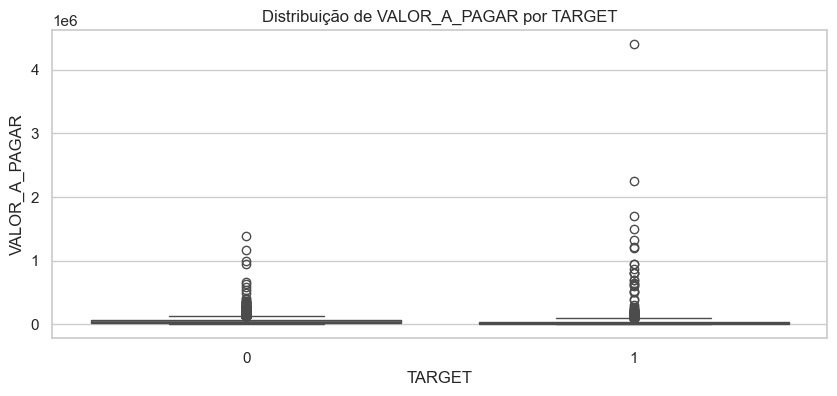

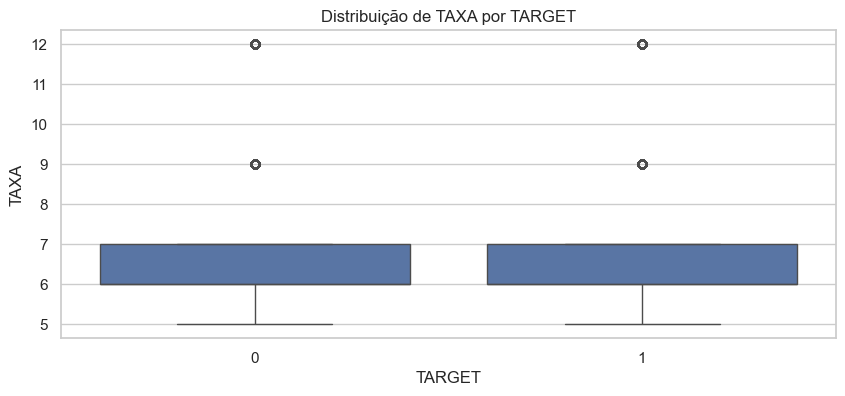

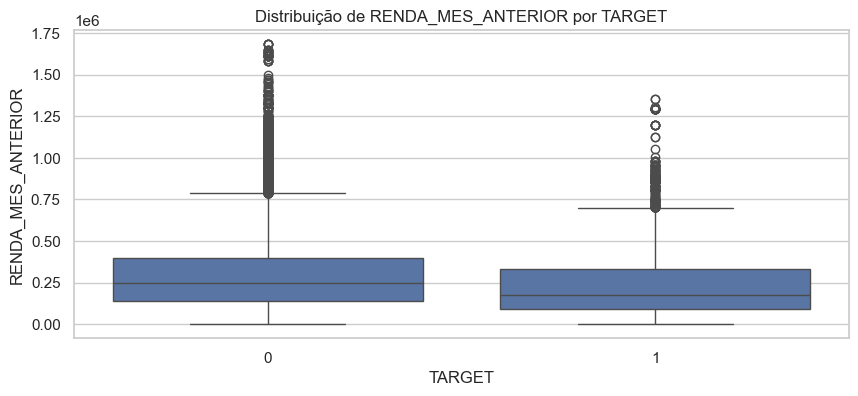

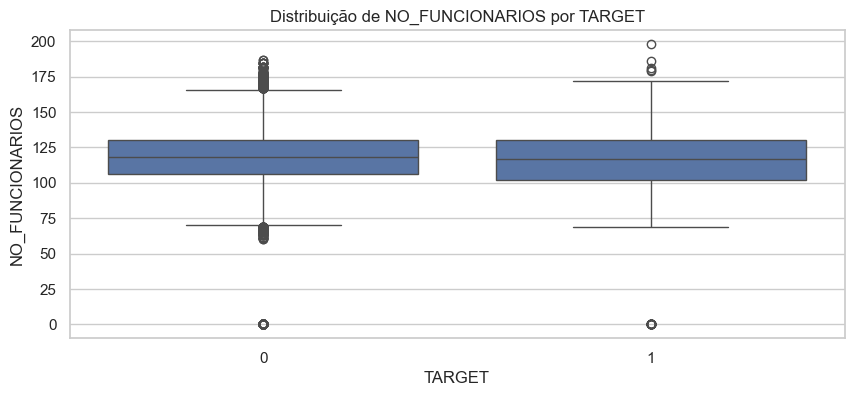

In [61]:
# Plotagem das distribuições das variáveis numéricas por TARGET
num_cols = ['VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']

for col in num_cols:
    plt.figure(figsize = (10, 4))
    sns.boxplot(data = dev_full, x = 'TARGET', y = col)
    plt.title(f'Distribuição de {col} por TARGET')
    plt.show()

- **VALOR_A_PAGAR:** distribuição altamente assimétrica, com muitos outliers e grande variabilidade no valor das cobranças;  
- **TAXA:** variável mais estável, com distribuições muito semelhantes entre adimplentes e inadimplentes;
- **RENDA_MES_ANTERIOR:** assimétrica, com presença de valores extremos elevados entre os outliers;
- **NO_FUNCIONARIOS:** distribuição mais concentrada e parecida entre os grupos, indicando baixa separação pelo TARGET;
- **Resumo:** as diferenças entre TARGET = 0 e 1 são sutis nas variáveis numéricas, reforçando a dificuldade natural do problema. 

### 7.7. Correlações entre Variáveis Numéricas

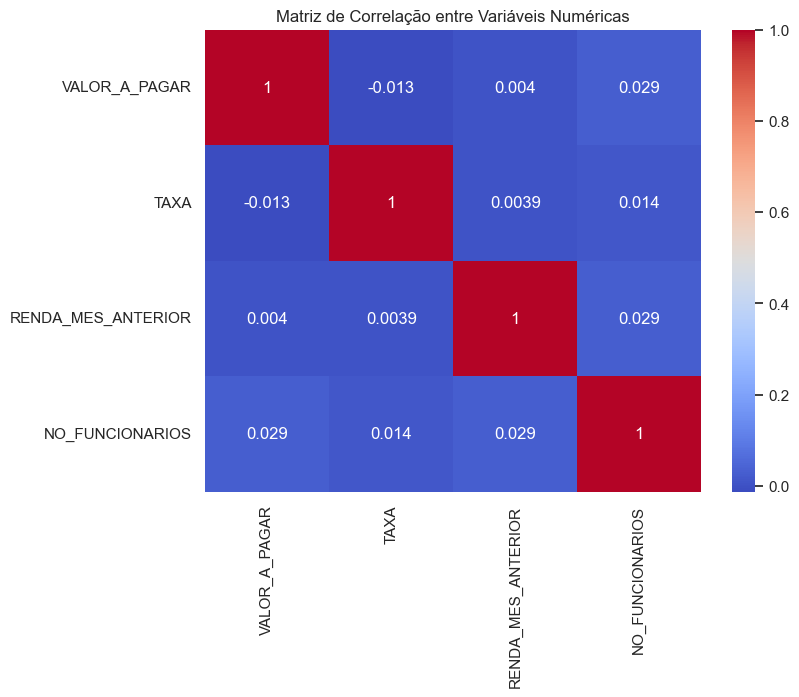

In [62]:
# Matriz de correlação entre variáveis numéricas
plt.figure(figsize = (8, 6))
sns.heatmap(dev_full[num_cols].corr(), annot = True, cmap = 'coolwarm')
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()

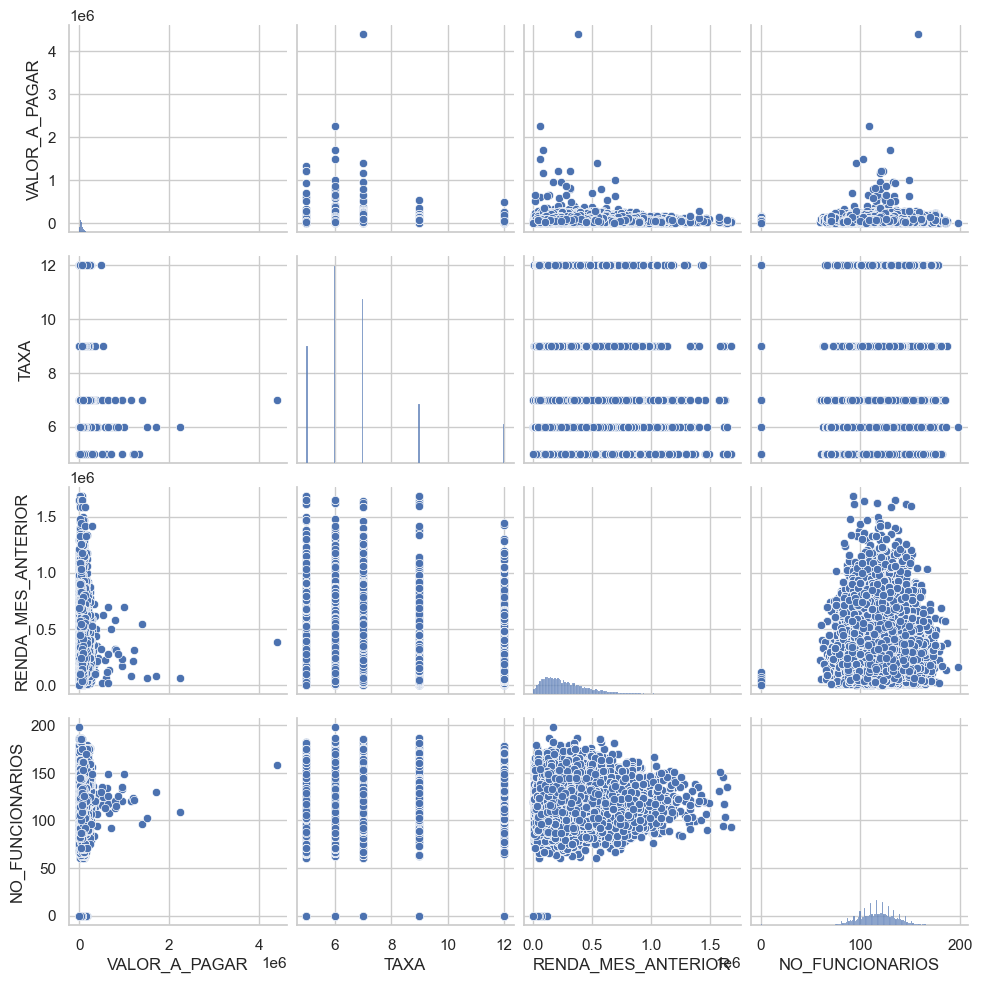

In [63]:
sns.pairplot(dev_full[num_cols])
plt.show()

A matriz de correlação, bem como os scatter plots, mostram que as variáveis numéricas são praticamente independentes entre si, com coeficientes muito próximos de zero. Isso indica ausência de colinearidade relevante e sugere que cada variável contribui de forma relativamente autônoma para o modelo. Nenhum relacionamento linear forte foi identificado.

### 7.8. Conclusões da Análise Exploratória

De forma geral, a análise exploratória indica que as variáveis numéricas são
altamente assimétricas e contendo outliers, enquanto as categóricas apresentam
distribuições estáveis e adequadas para codificação. A variável-alvo apresenta desbalanceamento
e não há separação evidente entre os grupos apenas a
partir das variáveis individuais. Esses achados orientam diretamente a próxima etapa, dedicada ao
tratamento dos valores ausentes, codificação das variáveis e construção de
novos atributos.


## 8. Feature Engineering

### 8.1. Introdução à Feature Engineering

Nesta seção realizamos o *feature engineering* para preparar os dados para modelagem, com o objetivo de:

- Tratar valores ausentes;
- Ajustar tipos das variáveis;  
- Criar novas variáveis derivadas;  
- Validar os datasets finais de treino e teste. 

Esse conjunto de transformações melhora a qualidade das informações fornecidas ao modelo e contribui para melhor performance preditiva.

### 8.2. Tratamento de Valores Ausentes

O tratamento dos valores ausentes foi realizado de forma simples e consistente com a análise exploratória. A coluna `FLAG_PF`, com cerca de 99% de faltantes, foi descartada por não oferecer informação útil ao modelo. As variáveis numéricas com missing (`RENDA_MES_ANTERIOR`, `NO_FUNCIONARIOS` e `VALOR_A_PAGAR`) foram imputadas pela mediana, estratégia robusta a outliers e adequada para distribuições assimétricas. Já as variáveis categóricas com faltantes (`PORTE`, `DDD`, `DOMINIO_EMAIL`, entre outras) receberam a categoria `'NA'`, preservando a consistência do dataset. As demais colunas não apresentaram valores ausentes e não requereram tratamento.

In [64]:
# Remoção da variável 'FLAG_PF', com quase 100% de valores ausentes
dev_full = dev_full.drop(columns = ['FLAG_PF'])
test_full = test_full.drop(columns = ['FLAG_PF'])

# Listas de variáveis 
num_impute = ['RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'VALOR_A_PAGAR']
cat_impute = ["PORTE", "DDD", "DOMINIO_EMAIL", "SEGMENTO_INDUSTRIAL", "CEP_2_DIG"]

# Imputação numérica: mediana
for col in num_impute:
    mediana = dev_full[col].median()
    dev_full[col] = dev_full[col].fillna(mediana)
    test_full[col] = test_full[col].fillna(mediana)
    
# Imputação categórica com 'NA'
for col in cat_impute:
    dev_full[col] = dev_full[col].fillna('NA')
    test_full[col] = test_full[col].fillna('NA')

### 8.3. Features Derivadas e Padronização de Tipos

Foram criadas três novas features que capturam informações temporais e
financeiras relevantes para o modelo:

- `PRAZO_EMISSAO_VENC` representa o número de dias entre a emissão e o vencimento da cobrança, um indicador potencial de pressão de prazo;
- `SAFRA_ANO` e `SAFRA_MES` foram extraídas de `SAFRA_REF` (formato 'YYYY-MM') utilizando fatiamentos: `str[:4]` para os quatro primeiros caracteres (correspondentes ao ano) e `str[- 2:]` para os dois últimos (correspondentes ao mês);
- `TAXA_RELATIVA` corresponde ao produto entre `TAXA` e `VALOR_A_PAGAR`, refletindo o custo relativo da taxa aplicada sobre cada cobrança.

In [ ]:
# Cria a feature 'PRAZO_EMISSAO_VENC' - Dias entre emissão e vencimento
dev_full['PRAZO_EMISSAO_VENC'] = (
    (dev_full['DATA_VENCIMENTO'] - dev_full['DATA_EMISSAO_DOCUMENTO']).dt.days
)
test_full['PRAZO_EMISSAO_VENC'] = (
    (test_full['DATA_VENCIMENTO'] - test_full['DATA_EMISSAO_DOCUMENTO']).dt.days
)

# Cria as features 'SAFRA_ANO' e 'SAFRA_MES' - Ano e mês extraídos de 'SAFRA_REF'
dev_full['SAFRA_ANO'] = dev_full['SAFRA_REF'].str[:4].astype(int)
dev_full['SAFRA_MES'] = dev_full['SAFRA_REF'].str[- 2:].astype(int)

test_full['SAFRA_ANO'] = test_full['SAFRA_REF'].str[:4].astype(int)
test_full['SAFRA_MES'] = test_full['SAFRA_REF'].str[-2:].astype(int)

# Cria a feature 'TAXA_RELATIVA' - Produto entre 'TAXA' e 'VALOR_A_PAGAR'
dev_full['TAXA_RELATIVA'] = dev_full['TAXA'] * dev_full['VALOR_A_PAGAR']
test_full['TAXA_RELATIVA'] = test_full['TAXA'] * test_full['VALOR_A_PAGAR']

In [66]:
# Converte colunas categóricas especificadas para o tipo 'category' nos datasets de desenvolvimento e teste
cat_cols = ['SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG']

for col in cat_cols:
    dev_full[col] = dev_full[col].astype('category')
    test_full[col] = test_full[col].astype('category')

### 8.4. Validação Pós-Feature Engineering

In [67]:
# Verificação de tipos finais
print("Tipos finais das variáveis:")
display(dev_full.dtypes)

# Checagem de valores ausentes
print("\nValores ausentes no dataset de desenvolvimento:")
display(dev_full.isnull().sum())

print("\nValores ausentes no dataset de teste:")
display(test_full.isnull().sum())

# Dimensões finais
print("\nDimensões finais:")
print("Dev:", dev_full.shape)
print("Test:", test_full.shape)

Tipos finais das variáveis:


ID_CLIENTE                         int64
SAFRA_REF                         object
DATA_EMISSAO_DOCUMENTO    datetime64[ns]
DATA_PAGAMENTO            datetime64[ns]
DATA_VENCIMENTO           datetime64[ns]
VALOR_A_PAGAR                    float64
TAXA                             float64
DIAS_ATRASO                        int64
TARGET                             int64
DATA_CADASTRO             datetime64[ns]
DDD                               object
SEGMENTO_INDUSTRIAL             category
DOMINIO_EMAIL                   category
PORTE                           category
CEP_2_DIG                       category
RENDA_MES_ANTERIOR               float64
NO_FUNCIONARIOS                  float64
PRAZO_EMISSAO_VENC                 int64
SAFRA_ANO                          int64
SAFRA_MES                          int64
TAXA_RELATIVA                    float64
dtype: object


Valores ausentes no dataset de desenvolvimento:


ID_CLIENTE                0
SAFRA_REF                 0
DATA_EMISSAO_DOCUMENTO    0
DATA_PAGAMENTO            0
DATA_VENCIMENTO           0
VALOR_A_PAGAR             0
TAXA                      0
DIAS_ATRASO               0
TARGET                    0
DATA_CADASTRO             0
DDD                       0
SEGMENTO_INDUSTRIAL       0
DOMINIO_EMAIL             0
PORTE                     0
CEP_2_DIG                 0
RENDA_MES_ANTERIOR        0
NO_FUNCIONARIOS           0
PRAZO_EMISSAO_VENC        0
SAFRA_ANO                 0
SAFRA_MES                 0
TAXA_RELATIVA             0
dtype: int64


Valores ausentes no dataset de teste:


ID_CLIENTE                 0
SAFRA_REF                  0
DATA_EMISSAO_DOCUMENTO     0
DATA_VENCIMENTO            0
VALOR_A_PAGAR              0
TAXA                       0
DATA_CADASTRO             38
DDD                        0
SEGMENTO_INDUSTRIAL        0
DOMINIO_EMAIL              0
PORTE                      0
CEP_2_DIG                  0
RENDA_MES_ANTERIOR         0
NO_FUNCIONARIOS            0
PRAZO_EMISSAO_VENC         0
SAFRA_ANO                  0
SAFRA_MES                  0
TAXA_RELATIVA              0
dtype: int64


Dimensões finais:
Dev: (77414, 21)
Test: (12275, 18)


A validação pós-Feature Engineering demonstra que as transformações foram aplicadas corretamente: as variáveis possuem os tipos esperados para o processo de modelagem e o dataset de desenvolvimento não apresenta valores ausentes, permitindo o uso direto nos modelos. 

Na base de teste, os únicos valores faltantes aparecem em campos que não são utilizados como preditores (por exemplo, `DATA_CADASTRO`), o que não impacta o pipeline de modelagem.  
Com isso, os dados estão completamente preparados para a definição dos conjuntos de treino e validação na próxima seção.

## 9. Preparação Final dos Dados para Modelagem

### 9.1. Introdução

Nesta etapa organizamos os dados para a modelagem, separando a variável-alvo (`TARGET`) dos atributos preditores e definindo a estrutura de pré-processamento que será aplicada aos modelos. Essa preparação garante que todas as variáveis sejam tratadas de forma consistente e que o pipeline possa ser reproduzido tanto no conjunto de validação quanto no conjunto de teste.


### 9.2. Definição de X e y

Separamos a variável-alvo (`TARGET`) do conjunto de atributos preditores. Também preparamos a base de teste para uso posterior, mantendo a mesma estrutura de variáveis do conjunto de desenvolvimento.

In [70]:
# Variável alvo
y = dev_full['TARGET']

# Conjunto de preditores
X = dev_full.drop(columns = ['TARGET'])

# Base de teste — já consolidada e sem TARGET
X_test = test_full.copy()

### 9.3. Pipeline de Pré-processamento

Utilizamos `ColumnTransformer` para combinar múltiplos pré-processamentos em um único passo. Ele permite especificar quais colunas serão transformadas por quais métodos, assegurando que:

- variáveis numéricas sejam padronizadas (`StandardScaler`);
- variáveis categóricas sejam convertidas em variáveis dummies 
  (`OneHotEncoder`);
- todas as transformações sejam aplicadas de forma consistente nos conjuntos
  de treino, validação e teste.

Esse mecanismo evita erros comuns (como aplicar transformação na coluna errada) e deixa o pipeline mais organizado e reprodutível.  

In [73]:
# Listas de variáveis numéricas e categóricas para o pré-processamento
num_cols = [
    'VALOR_A_PAGAR',
    'TAXA',
    'RENDA_MES_ANTERIOR',
    'NO_FUNCIONARIOS',
    'PRAZO_EMISSAO_VENC',
    'SAFRA_ANO',
    'SAFRA_MES',
    'TAXA_RELATIVA'
]

cat_cols = [
    'SEGMENTO_INDUSTRIAL',
    'DOMINIO_EMAIL',
    'PORTE',
    'CEP_2_DIG',
]

In [87]:
# Pré-processamento: escala numéricas e aplica One-Hot às categóricas
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

preprocess = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), cat_cols)
    ]
)

Concluímos a preparação final para a modelagem validando a estrutura do pré-processador e garantindo que os dados estão prontos para a etapa de treino e validação. A partir daqui, todos os modelos poderão ser treinados de forma reproduzível e consistente utilizando este pipeline.


## 10. Separação em Treino e Validação

### 10.1. Introdução

Nesta seção dividimos o conjunto de desenvolvimento em duas partes: treinamento e validação. Essa divisão permite avaliar o desempenho dos modelos em dados nunca vistos, reduzindo overfitting e fornecendo uma medida mais realista da performance. 

Como a variável-alvo é desbalanceada, utilizamos estratificação para manter a proporção original de inadimplentes e adimplentes em ambos os conjuntos.

### 10.2. Execução do `train_test_split` com Estratificação

In [85]:
# Importa a função train_test_split
from sklearn.model_selection import train_test_split

# Divide os dados em treino e validação preservando a proporção de TARGET (estratificação)
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size = 0.2,
    stratify = y,
    random_state = RANDOM_STATE
)

In [82]:
# Verifica se a proporção da TARGET foi preservada após o split
print('Proporção no treino:')
print(y_train.value_counts(normalize = True).rename('proporção'))

print('\nProporção na validação:')
print(y_valid.value_counts(normalize = True).rename('proporção'))


Proporção no treino:
TARGET
0    0.929777
1    0.070223
Name: proporção, dtype: float64

Proporção na validação:
TARGET
0    0.929794
1    0.070206
Name: proporção, dtype: float64


A distribuição da variável `TARGET` se manteve praticamente idêntica nos conjuntos de treino e validação, indicando que a estratificação funcionou corretamente. Isso garante que a avaliação dos modelos reflita o desbalanceamento real do problema.

### 10.3. Checagem das Dimensões Finais 

In [83]:
print('Dimensões finais:')
print('X_train:', X_train.shape)
print('X_valid:', X_valid.shape)
print('y_train:', y_train.shape)
print('y_valid:', y_valid.shape)

Dimensões finais:
X_train: (61931, 20)
X_valid: (15483, 20)
y_train: (61931,)
y_valid: (15483,)


Com a separação entre treino e validação concluída, os dados estão prontos para a etapa de modelagem. Na próxima seção, ajustaremos diferentes classificadores utilizando o pipeline de pré-processamento definido anteriormente.


## 11. Modelagem 

### 11.1. Introdução à Modelagem

Nesta seção realizamos o treinamento de diferentes modelos de classificação, utilizando o pipeline de pré-processamento definido anteriormente. O objetivo é comparar algoritmos lineares e baseados em árvores para prever a inadimplência. 

Como o problema apresenta forte desbalanceamento, utilizamos métricas robustas como AUC-ROC e Log Loss, além de habilitar `class_weight = 'balanced'` quando aplicável.


### 11.2. Treinamento dos Modelos

Nesta etapa utilizamos três modelos de classificação para analisar o problema de inadimplência. Começamos com um modelo linear simples, a `Regressão
Logística`, que funciona como baseline interpretável e estabelece uma linha de comparação. Em seguida, avaliamos dois modelos baseados em árvores, `Random Forest` e `XGBoost`, de maior robustez e capazes de capturar relações não lineares e interações entre variáveis que modelos lineares não conseguem aprender.

Todos os modelos são combinados ao pipeline de pré-processamento definido na seção anterior. Esse pipeline padroniza automaticamente as variáveis numéricas e codifica as variáveis categóricas via OHE, garantindo que as transformações sejam aplicadas de forma consistente nos conjuntos de treino, validação e teste. Dessa forma, cada modelo recebe os dados já tratados e prontos para ajuste, permitindo uma comparação justa e reprodutível entre os algoritmos.

In [86]:
# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Modelagem e métricas
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    confusion_matrix
)

### 11.2.1. Regressão Logística

In [ ]:
# Pipeline com Regressão Logística
lr_pipeline = Pipeline(steps = [
    ('preprocess', preprocess),
    ('model', LogisticRegression(
        class_weight = 'balanced',
        random_state = RANDOM_STATE,
        max_iter = 1000
    ))
])

# Treinamento
lr_pipeline.fit(X_train, y_train)

# Predições na base de validação
y_pred_proba_lr = lr_pipeline.predict_proba(X_valid)[:, 1]
y_pred_lr = lr_pipeline.predict(X_valid)

# Cálculo das métricas AUC-ROC e Log Loss
auc_lr = roc_auc_score(y_valid, y_pred_proba_lr)
log_loss_lr = log_loss(y_valid, y_pred_proba_lr)

auc_lr, log_loss_lr

(np.float64(0.8130090120096224), 0.5348906868170517)

### 11.2.2. Random Forest

In [94]:
# Pipeline com Random Forest
rf_pipeline = Pipeline(steps = [
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(
        n_estimators = 300,
        min_samples_split = 5,
        class_weight = 'balanced',
        random_state = RANDOM_STATE,
    ))
])

# Treinamento
rf_pipeline.fit(X_train, y_train)

# Predições na base de validação
y_pred_proba_rf = rf_pipeline.predict_proba(X_valid)[:, 1]
y_pred_rf = rf_pipeline.predict(X_valid)

# Cálculo das métricas AUC-ROC e Log Loss
auc_rf = roc_auc_score(y_valid, y_pred_proba_rf)
log_loss_rf = log_loss(y_valid, y_pred_proba_rf)

auc_rf, log_loss_rf

(np.float64(0.9618388770978752), 0.11729827892294027)

### 11.2.3. XGBoost

In [ ]:
# Pipeline com XGBoost
xgb_pipeline = Pipeline(steps = [
    ('preprocess', preprocess),
    ('model', XGBClassifier(
        n_estimators = 400,
        learning_rate = 0.05,
        max_depth = 6,
        subsample = 0.9,
        colsample_bytree = 0.8,
        eval_metric = 'logloss',
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
        random_state = RANDOM_STATE,
    ))
])

# Treinamento
xgb_pipeline.fit(X_train, y_train)

# Predições na base de validação
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_valid)[:, 1]
y_pred_xgb = xgb_pipeline.predict(X_valid)

# Cálculo das métricas AUC-ROC e Log Loss
auc_xgb = roc_auc_score(y_valid, y_pred_proba_xgb)
log_loss_xgb = log_loss(y_valid, y_pred_proba_xgb)

auc_xgb, log_loss_xgb   

(np.float64(0.9453350401688295), 0.2635261935620013)

O Random Forest apresentou um desempenho inicial sólido, com as métricas AUC-ROC e Log Loss em níveis competitivos. Esses resultados indicam que o modelo captura bem os padrões dos dados. Na próxima seção, faremos uma comparação entre os modelos testados para selecionar o melhor candidato para ajuste de hiperparâmetros.

### 11.3. Conclusão

Nesta seção treinamos três modelos para o problema: Regressão Logística (baseline linear), Random Forest (ensemble baseado em bagging) e XGBoost (gradient boosting). As métricas individuais de cada modelo foram registradas e, na próxima seção, realizaremos a avaliação comparativa detalhada para determinar o modelo final.

## 12. Avaliação e Comparação dos Modelos

### 12.1. Introdução à Avaliação

Com os modelos treinados, esta seção se dedica a comparar seu desempenho utilizando métricas adequadas para problemas desbalanceados, como AUC-ROC e Log Loss. Também analisamos matrizes de confusão e relatórios de classificação para compreender o comportamento de cada algoritmo no acerto das classes.

In [107]:
# Organiza os resultados em um DataFrame
results = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'Random Forest', 'XGBoost'],
    'AUC-ROC': [auc_lr, auc_rf, auc_xgb],
    'Log Loss': [log_loss_lr, log_loss_rf, log_loss_xgb]
})

results.sort_values(by = 'AUC-ROC', ascending = False).reset_index(drop = True)
results

,Modelo,AUC-ROC,Log Loss
0,Regressão Logística,0.813009,0.534891
1,Random Forest,0.961839,0.117298
2,XGBoost,0.945335,0.263526


A comparação entre os modelos evidencia diferenças claras de desempenho. A Regressão Logística serve como baseline, mas apresenta capacidade limitada tanto em separação das classes (AUC) quanto em calibração das probabilidades (Log Loss). O XGBoost melhora significativamente o AUC, porém suas probabilidades permanecem mal calibradas, resultando em um Log Loss relativamente alto. O Random Forest se destaca como a melhor solução, combinando excelente poder discriminativo (AUC-ROC de 0.96) com ótima calibração (menor Log Loss). Assim, ele representa o modelo mais robusto e confiável para produção.

### 12.2. Relatórios de Classificação e Matrizes de Confusão

### Relatórios de Classificação

In [142]:
# Função para imprimir métricas detalhadas, utilizando classification_report e confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

def print_metrics(model_name, y_true, y_pred):
    print('=' * 40)
    print(f"{model_name}")
    print('=' * 40)
    print('\nClassification Report:\n')
    print(classification_report(y_true, y_pred, digits = 4))
    print('\n\n')

In [143]:
print_metrics('Regressão Logística', y_valid, y_pred_lr)

Regressão Logística

Classification Report:

              precision    recall  f1-score   support

           0     0.9734    0.7437    0.8432     14396
           1     0.1771    0.7305    0.2851      1087

    accuracy                         0.7428     15483
   macro avg     0.5752    0.7371    0.5642     15483
weighted avg     0.9175    0.7428    0.8040     15483






In [144]:
print_metrics('Random Forest', y_valid, y_pred_rf)

Random Forest

Classification Report:

              precision    recall  f1-score   support

           0     0.9740    0.9837    0.9788     14396
           1     0.7511    0.6523    0.6982      1087

    accuracy                         0.9604     15483
   macro avg     0.8625    0.8180    0.8385     15483
weighted avg     0.9583    0.9604    0.9591     15483






In [145]:
print_metrics('XGBoost', y_valid, y_pred_xgb)

XGBoost

Classification Report:

              precision    recall  f1-score   support

           0     0.9882    0.9109    0.9480     14396
           1     0.4207    0.8565    0.5642      1087

    accuracy                         0.9071     15483
   macro avg     0.7045    0.8837    0.7561     15483
weighted avg     0.9484    0.9071    0.9211     15483






### Matrizes de Confusão

In [139]:
# Função para plotar a matriz de confusão
def plot_confusion(model_name, y_true, y_pred):
    """Plota a matriz de confusão para o modelo especificado."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize = (5, 4))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
                xticklabels = ['Predito 0', 'Predito 1'],
                yticklabels = ['Real 0', 'Real 1'])
    plt.title(f"Matriz de Confusão: {model_name}")
    plt.ylabel("Real")
    plt.xlabel("Predito")
    plt.show()

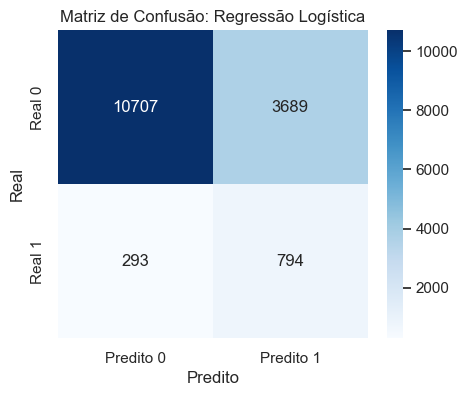

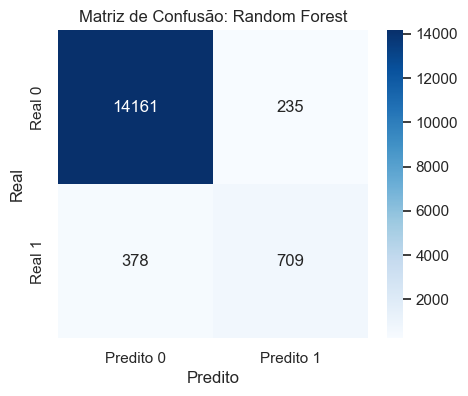

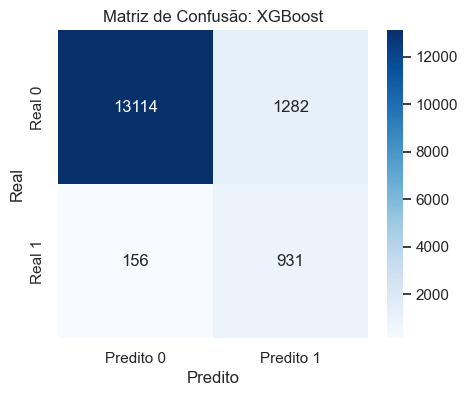

In [ ]:
plot_confusion('Regressão Logística', y_valid, y_pred_lr)
plot_confusion('Random Forest', y_valid, y_pred_rf)
plot_confusion('XGBoost', y_valid, y_pred_xgb)

Os relatórios de classificação e matrizes de confusão evidenciam diferenças importantes entre os modelos avaliados.  

A Regressão Logística, utilizada como baseline, apresenta bom desempenho para a classe 0, mas mostra forte dificuldade em identificar inadimplentes (classe 1), gerando grande quantidade de falsos positivos e resultando em baixa precisão.  

O XGBoost tem excelente capacidade de recuperação da classe 1 (recall muito alto), porém à custa de um número elevado de falsos positivos, o que pode ser inviável em um cenário de risco de crédito, onde decisões incorretas geram custos operacionais e financeiros significativos.

O Random Forest é o modelo mais equilibrado: possui alta separação entre as classes (AUC elevada), ótima precisão e recall tanto para adimplentes quanto para inadimplentes, e reduz consideravelmente os erros críticos observados nos outros modelos. Sua matriz de confusão demonstra poucos falsos positivos e um número controlado de falsos negativos, tornando-o a alternativa mais estável e confiável para o objetivo do case.

### 12.3. Gráficos Comparativos

### AUC-ROC e Log Loss

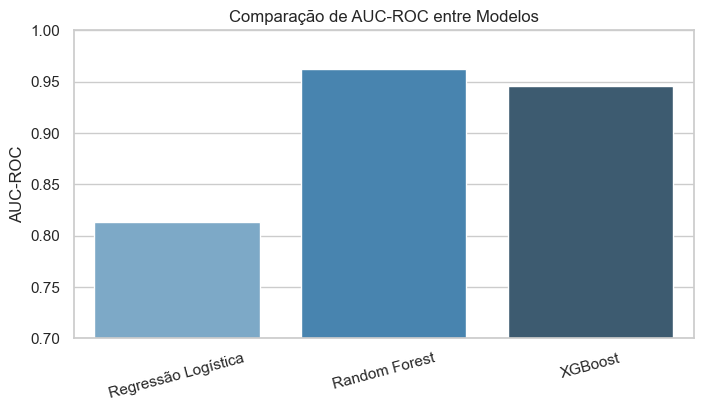

In [ ]:
# Gráfico comparativo de AUC-ROC
results_auc = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'Random Forest', 'XGBoost'],
    'AUC-ROC': [auc_lr, auc_rf, auc_xgb]
})

plt.figure(figsize = (8, 4))
sns.barplot(data = results_auc, x = 'Modelo', y = 'AUC-ROC', palette = 'Blues_d', hue = 'Modelo', dodge = False)
plt.title('Comparação de AUC-ROC entre Modelos')
plt.ylim(0.7, 1.0)
plt.ylabel('AUC-ROC')
plt.xlabel('')
plt.xticks(rotation = 15)
plt.show()

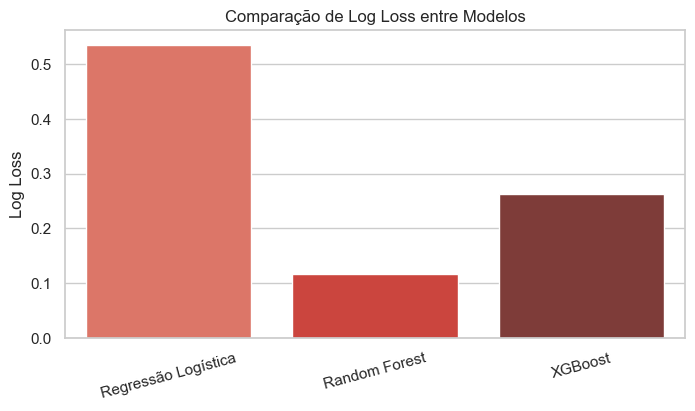

In [ ]:
# Gráfico comparativo de Log Loss
results_ll = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'Random Forest', 'XGBoost'],
    'Log Loss': [log_loss_lr, log_loss_rf, log_loss_xgb]
})

plt.figure(figsize = (8, 4))
sns.barplot(data=results_ll, x = 'Modelo', y = 'Log Loss', palette = 'Reds_d', hue = 'Modelo', dodge = False)
plt.title('Comparação de Log Loss entre Modelos')
plt.ylabel('Log Loss')
plt.xlabel('')
plt.xticks(rotation = 15)
plt.show()

Os gráficos de barras evidenciam a superioridade do Random Forest, que obteve o maior AUC-ROC e o menor Log Loss entre os modelos testados. Esses resultados apontam para melhor discriminação entre as classes e maior confiabilidade nas probabilidades previstas.

### Curvas ROC

<Figure size 800x600 with 0 Axes>

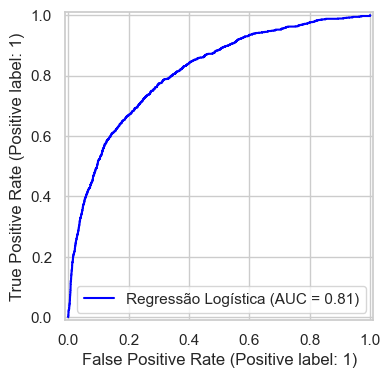

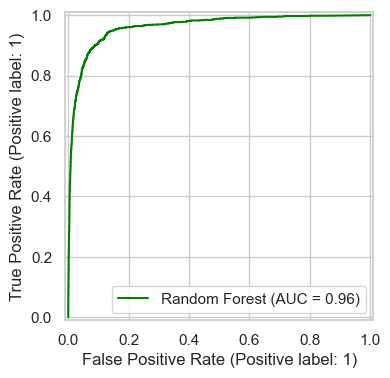

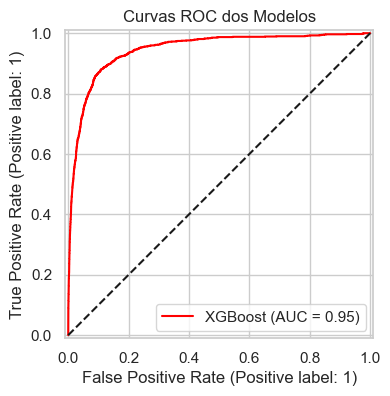

In [136]:
# Plota as curvas ROC dos modelos
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize = (8, 6))

RocCurveDisplay.from_predictions(y_valid, y_pred_proba_lr, name = 'Regressão Logística', color = 'blue')
RocCurveDisplay.from_predictions(y_valid, y_pred_proba_rf, name = 'Random Forest', color = 'green')
RocCurveDisplay.from_predictions(y_valid, y_pred_proba_xgb, name = 'XGBoost', color = 'red')

plt.plot([0,1], [0,1], 'k--')
plt.title('Curvas ROC dos Modelos')
plt.show()

As curvas ROC confirmam visualmente o melhor desempenho do Random Forest, que apresenta maior área sob a curva ao longo de toda a faixa de sensibilidade.
Isso demonstra maior capacidade de distinguir corretamente entre adimplentes e inadimplentes.

### 12.4. Conclusão

Os resultados numéricos e gráficos reforçam a superioridade do Random Forest, que apresentou o maior AUC-ROC, o menor Log Loss e o melhor equilíbrio entre precisão e recall da classe minoritária. Sua robustez e estabilidade tornam o modelo mais adequado para estimar a probabilidade de inadimplência neste case.  

A seguir, utilizaremos o Random Forest para gerar as previsões no conjunto de teste e construir o arquivo final de submissão.

## 13. Validação Cruzada e Ajuste de Hiperparâmetros do Modelo Final

### 13.1. Introdução 

Após a comparação aprofundada apresentada na Seção 12, o Random Forest foi selecionado como o melhor modelo para o problema, destacando-se tanto em AUC-ROC quanto em Log Loss, além de apresentar excelente desempenho na classe minoritária. Sua capacidade de capturar relações não lineares e lidar bem com variáveis heterogêneas o tornou a escolha natural para a etapa de previsões no conjunto de teste.

Como próximo passo, antes de proceder ao fine tuning, realizamos uma validação cruzada (k-fold CV) para avaliar a estabilidade do desempenho do modelo e confirmar que seus resultados não foram dependentes do split específico de treino/validação.

Com essa estabilidade verificada, aplicamos então um RandomizedSearchCV para explorar um conjunto reduzido e controlado de hiperparâmetros, buscando melhorar a robustez do modelo, reduzir variância e calibrar suas probabilidades, mantendo o foco em ajustes leves e adequados ao nosso escopo.

### 13.2. Validação Cruzada do Random Forest

In [153]:
from sklearn.model_selection import cross_val_score

# Modelo utilizado no pipeline
rf_base = Pipeline(steps = [
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(
        n_estimators = 300,
        min_samples_split = 5,
        class_weight = 'balanced',
        random_state = RANDOM_STATE,
    ))
])

# Validação cruzada com 5 folds para AUC-ROC
cv_scores = cross_val_score(
    rf_base,
    X_train, y_train,
    cv = 5,
    scoring = 'roc_auc',
    n_jobs = - 1
)

print('AUC-ROC CV scores:', cv_scores)
print('Média AUC-ROC CV:', cv_scores.mean())

AUC-ROC CV scores: [0.96443718 0.95870027 0.95862423 0.96467838 0.95652535]
Média AUC-ROC CV: 0.9605930823162583


Os resultados da validação cruzada em 5 folds indicam que o Random Forest mantém desempenho estável ao longo das diferentes partições da base de treino, com AUC-ROC em torno de 0.96 e baixa variação entre os folds. Isso reforça que o bom resultado observado no conjunto de validação não é fruto de um split específico e reflete uma capacidade consistente de generalização do modelo.

### 13.3. Ajuste de Hiperparâmetros com RandomizedSearchCV

In [154]:
from sklearn.model_selection import RandomizedSearchCV

# Espaço de busca para hiperparâmetros do Random Forest
param_dist = {
    'model__n_estimators': [300, 400, 500],
    'model__max_depth': [None, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2']
}

# Configuração do RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    rf_base,
    param_distributions = param_dist,
    n_iter = 12,
    scoring = 'roc_auc',
    cv = 5,
    verbose = 0,
    n_jobs = - 1,
    random_state = RANDOM_STATE
)

# Treinamento do RandomizedSearchCV
rf_random_search.fit(X_train, y_train)
best_rf = rf_random_search.best_estimator_

# Exibe o melhor modelo encontrado
best_rf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['VALOR_A_PAGAR', 'TAXA',
                                                   'RENDA_MES_ANTERIOR',
                                                   'NO_FUNCIONARIOS',
                                                   'PRAZO_EMISSAO_VENC',
                                                   'SAFRA_ANO', 'SAFRA_MES',
                                                   'TAXA_RELATIVA']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SEGMENTO_INDUSTRIAL',
                                                   'DOMINIO_EMAIL', 'PORTE',
                                                   'CEP_2_DIG'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_split=5, n_estimators=500,
                                        random_state=0))])

Os hiperparâmetros abaixo representam a melhor combinação encontrada pelo RandomizedSearchCV segundo o critério de AUC-ROC médio em validação cruzada. Esse resultado confirma que o modelo ajustado mantém desempenho consistente e ligeiramente superior ao modelo base.

In [159]:
# Resultados do RandomizedSearchCV
rf_random_search.best_params_, rf_random_search.best_score_

({'model__n_estimators': 500,
  'model__min_samples_split': 5,
  'model__min_samples_leaf': 1,
  'model__max_features': 'sqrt',
  'model__max_depth': None},
 np.float64(0.9612544288378615))

### 13.4. Comparação do Modelo Otimizado com o Modelo Base

In [162]:
# Predições com o modelo otimizado
y_pred_proba_best_rf = best_rf.predict_proba(X_valid)[:, 1]
y_pred_best_rf = best_rf.predict(X_valid)

auc_rf_best = roc_auc_score(y_valid, y_pred_proba_best_rf)
logloss_rf_best = log_loss(y_valid, y_pred_proba_best_rf)

auc_rf_best, logloss_rf_best

(np.float64(0.9624185830010534), 0.11701018057766785)

In [161]:
# Previsões com o modelo base (como na subseção 11.2.2)
y_pred_proba_rf_base = rf_pipeline.predict_proba(X_valid)[:, 1]

auc_rf_base = roc_auc_score(y_valid, y_pred_proba_rf_base)
logloss_rf_base = log_loss(y_valid, y_pred_proba_rf_base)

auc_rf_base, logloss_rf_base


(np.float64(0.9618388770978752), 0.11729827892294027)

In [164]:
comparison = pd.DataFrame({
    'Modelo': ['Random Forest (Base)', 'Random Forest (Best)'],
    'AUC-ROC': [auc_rf_base, auc_rf_best],
    'Log Loss': [logloss_rf_base, logloss_rf_best]
})

comparison

,Modelo,AUC-ROC,Log Loss
0,Random Forest (Base),0.961839,0.117298
1,Random Forest (Best),0.962419,0.117010


### 13.5. Conclusão

A comparação entre o Random Forest base e o modelo ajustado via RandomizedSearchCV mostra ganhos consistentes, ainda que modestos. O AUC-ROC aumentou de 0.9618 para 0.9624, indicando ligeira melhora na capacidade de discriminar entre pagadores e inadimplentes. O Log Loss reduziu de 0.11730 para 0.11701, sugerindo probabilidades um pouco mais bem calibradas.

Essas melhorias sutis são esperadas em um cenário onde o modelo base já apresentava bom desempenho. O tuning atua refinando o comportamento do modelo, especialmente na calibração das probabilidades. Assim, adotamos o Random Forest ajustado como versão final a ser utilizada na etapa de previsão sobre o conjunto de teste.

## 14. Previsões no Conjunto de Teste

Após o processo de seleção (Seção 12) e fine tuning do modelo (Seção 13), o Random Forest (`best_rf`) ajustado foi escolhido como modelo final por apresentar o melhor desempenho tanto em AUC-ROC quanto em Log Loss, além de boa estabilidade sob validação cruzada.

Nesta seção, utilizamos o modelo final para gerar as probabilidades de inadimplência para o conjunto de teste fornecido. Como a métrica solicitada no case é a probabilidade estimada de inadimplência, utilizamos `predict_proba` para obter o valor contínuo entre 0 e 1.


### 14.1. Treinamento do Modelo Final no Conjunto Completo de Desenvolvimento

Agora que a escolha do modelo foi concluída, treinamos o `best_rf` em todos os dados de desenvolvimento (X e y).

In [165]:
# Treina o modelo best_rf em todos os dados de desenvolvimento
best_rf.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['VALOR_A_PAGAR', 'TAXA',
                                                   'RENDA_MES_ANTERIOR',
                                                   'NO_FUNCIONARIOS',
                                                   'PRAZO_EMISSAO_VENC',
                                                   'SAFRA_ANO', 'SAFRA_MES',
                                                   'TAXA_RELATIVA']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SEGMENTO_INDUSTRIAL',
                                                   'DOMINIO_EMAIL', 'PORTE',
                                                   'CEP_2_DIG'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_split=5, n_estimators=500,
                                        random_state=0))])

### 14.2. Probabilidades de Inadimplência no Conjunto de Teste

In [166]:
# Gera as probabilidades de inadimplência no conjunto de teste
test_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Mostra as primeiras previsões para conferência
test_pred_proba[:10]

array([0.07895288, 0.00573767, 0.00573767, 0.00759723, 0.02586734,
       0.0219044 , 0.02897443, 0.03486459, 0.03502344, 0.0335257 ])

### 14.3. Construção do Arquivo de Submissão

In [ ]:
# Organiza as probabilidades em um DataFrame para submissão
submission = pd.DataFrame({
    'ID_CLIENTE': test_full['ID_CLIENTE'],
    'SAFRA_REF': test_full['SAFRA_REF'],
    'PROBABILIDADE_INADIMPLENCIA': test_pred_proba
})

submission.head()

,ID_CLIENTE,SAFRA_REF,PROBABILIDADE_INADIMPLENCIA
0,5058298901476893676,2021-07,0.078953
1,274692171162531764,2021-07,0.005738
2,274692171162531764,2021-07,0.005738
3,274692171162531764,2021-07,0.007597
4,465309249432033993,2021-07,0.025867


### 14.4. Geração do Arquivo CSV para Submissão

In [174]:
submission.to_csv('submissao_case.csv', index = False)

### 14.5. Conclusão

As probabilidades foram geradas utilizando o modelo Random Forest ajustado, treinado em 100% da base de desenvolvimento. O arquivo de submissão segue o formato solicitado e contém, para cada registro do conjunto de teste, a probabilidade estimada de inadimplência. Este arquivo representa a entrega final do case técnico.

## 15. Considerações Finais

O objetivo deste case foi desenvolver um modelo capaz de estimar a probabilidade de inadimplência após uma cobrança, utilizando as bases de dados fornecidas: pagamentos, cadastro e informações mensais por cliente. Ao longo do projeto, construímos um fluxo completo de ciência de dados, incluindo consolidação das bases, análise exploratória, tratamento de dados, feature engineering, modelagem, validação e seleção do modelo final.

A análise exploratória confirmou um forte desbalanceamento da variável-alvo e revelou padrões consistentes entre características cadastrais, valor das cobranças e comportamento de pagamento. Após a construção das features e do pré-processamento, avaliamos três modelos principais: Regressão Logística, XGBoost e Random Forest. O Random Forest destacou-se com o maior AUC-ROC e o menor Log Loss, especialmente apresentando ótima performance na classe minoritária.

Com base nesse resultado, aplicamos validação cruzada e ajuste leve de hiperparâmetros para verificar a estabilidade do modelo e aprimorar seu desempenho. O modelo final demonstrou consistência e robustez, mantendo AUC em torno de 0.96.

Por fim, utilizamos o modelo ajustado para gerar as probabilidades de inadimplência no conjunto de teste disponibilizado, produzindo o arquivo final `submissao_case.csv` de submissão, conforme solicitado no case.

## 16. Referências

[1] *Scikit-Learn Documentation.* Disponível em: https://scikit-learn.org/stable/documentation.html.

[2] GÉRON, A. **Mãos à Obra: Aprendizado de Máquina com Scikit-Learn, Keras e TensorFlow.** 2ª ed. Rio de Janeiro: Alta Books, 2021.  

[3] KLOSTERMAN, S. **Projetos de Ciência de Dados com Python.** São Paulo: Novatec, 2020.